In [34]:
import warnings

warnings.filterwarnings('ignore')


# **Proyecto 2 : Análisis de señales ECG**

## Andres Banquez- Melina Villada

1. De los artículos:

https://www.nature.com/articles/s41746-023-00966-w

https://www.nature.com/articles/s41598-020-59821-7

https://www.sciencedirect.com/science/article/pii/S2405844024032316

Para cada artículo hacer un diagrama de flujo de las metodologías usadas en los artículos (10%)

Explicar en sus palabras las metodologías desarrolladas (10%)



*Prediction of atrial fibrillation from at-home single-lead ECG signals without arrhythmias*

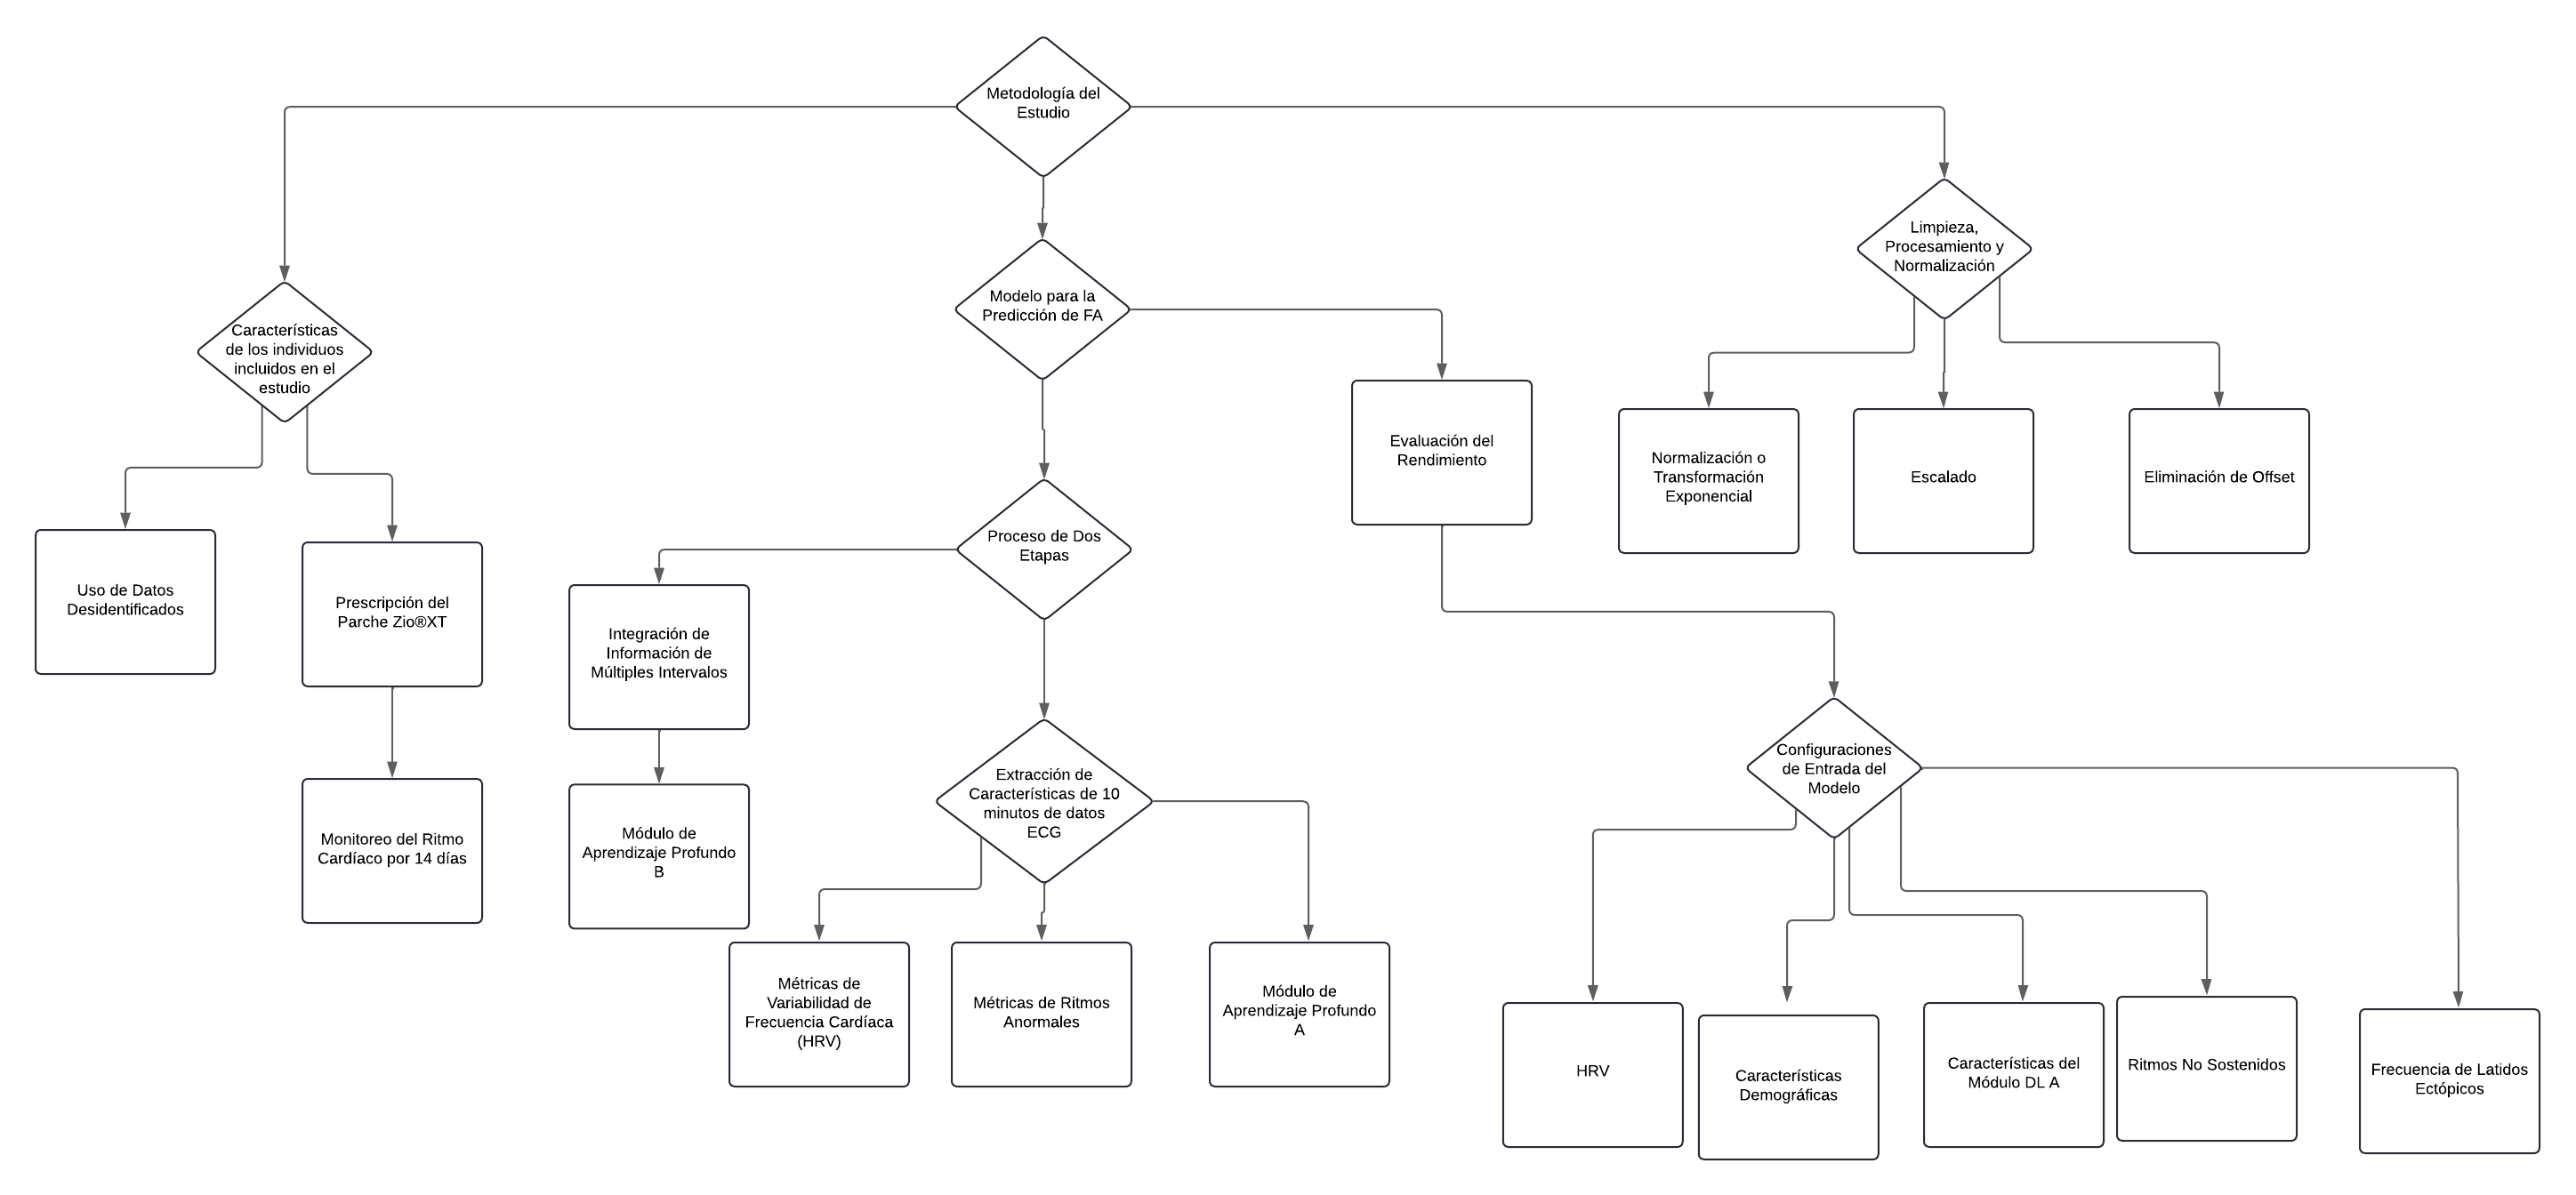

*Optimal Multi-Stage Arrhythmia Classification Approach*

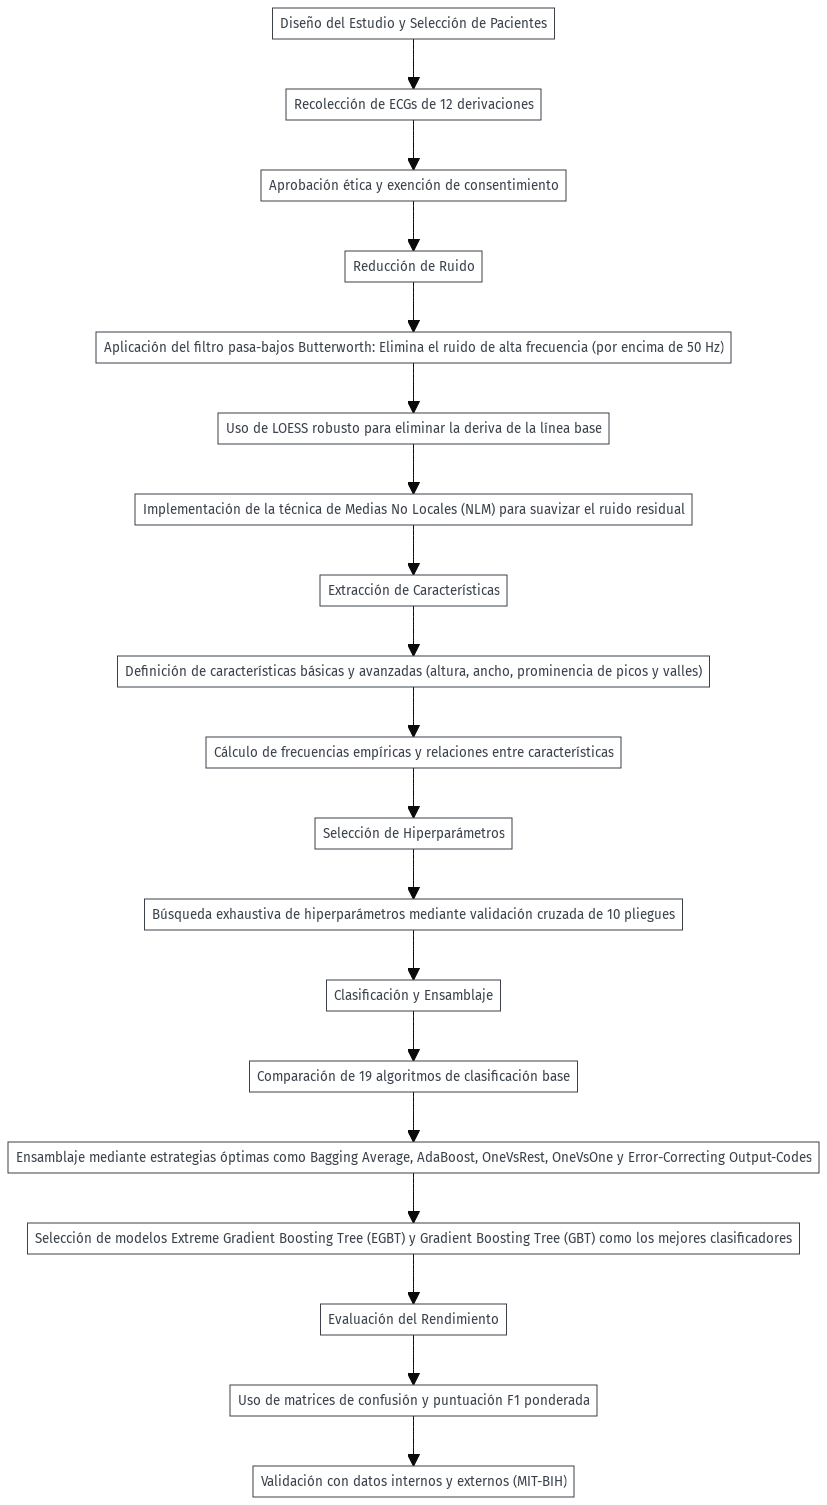

*An Arrhythmia classification approach via deep learning using single-lead ECG without QRS wave detection*

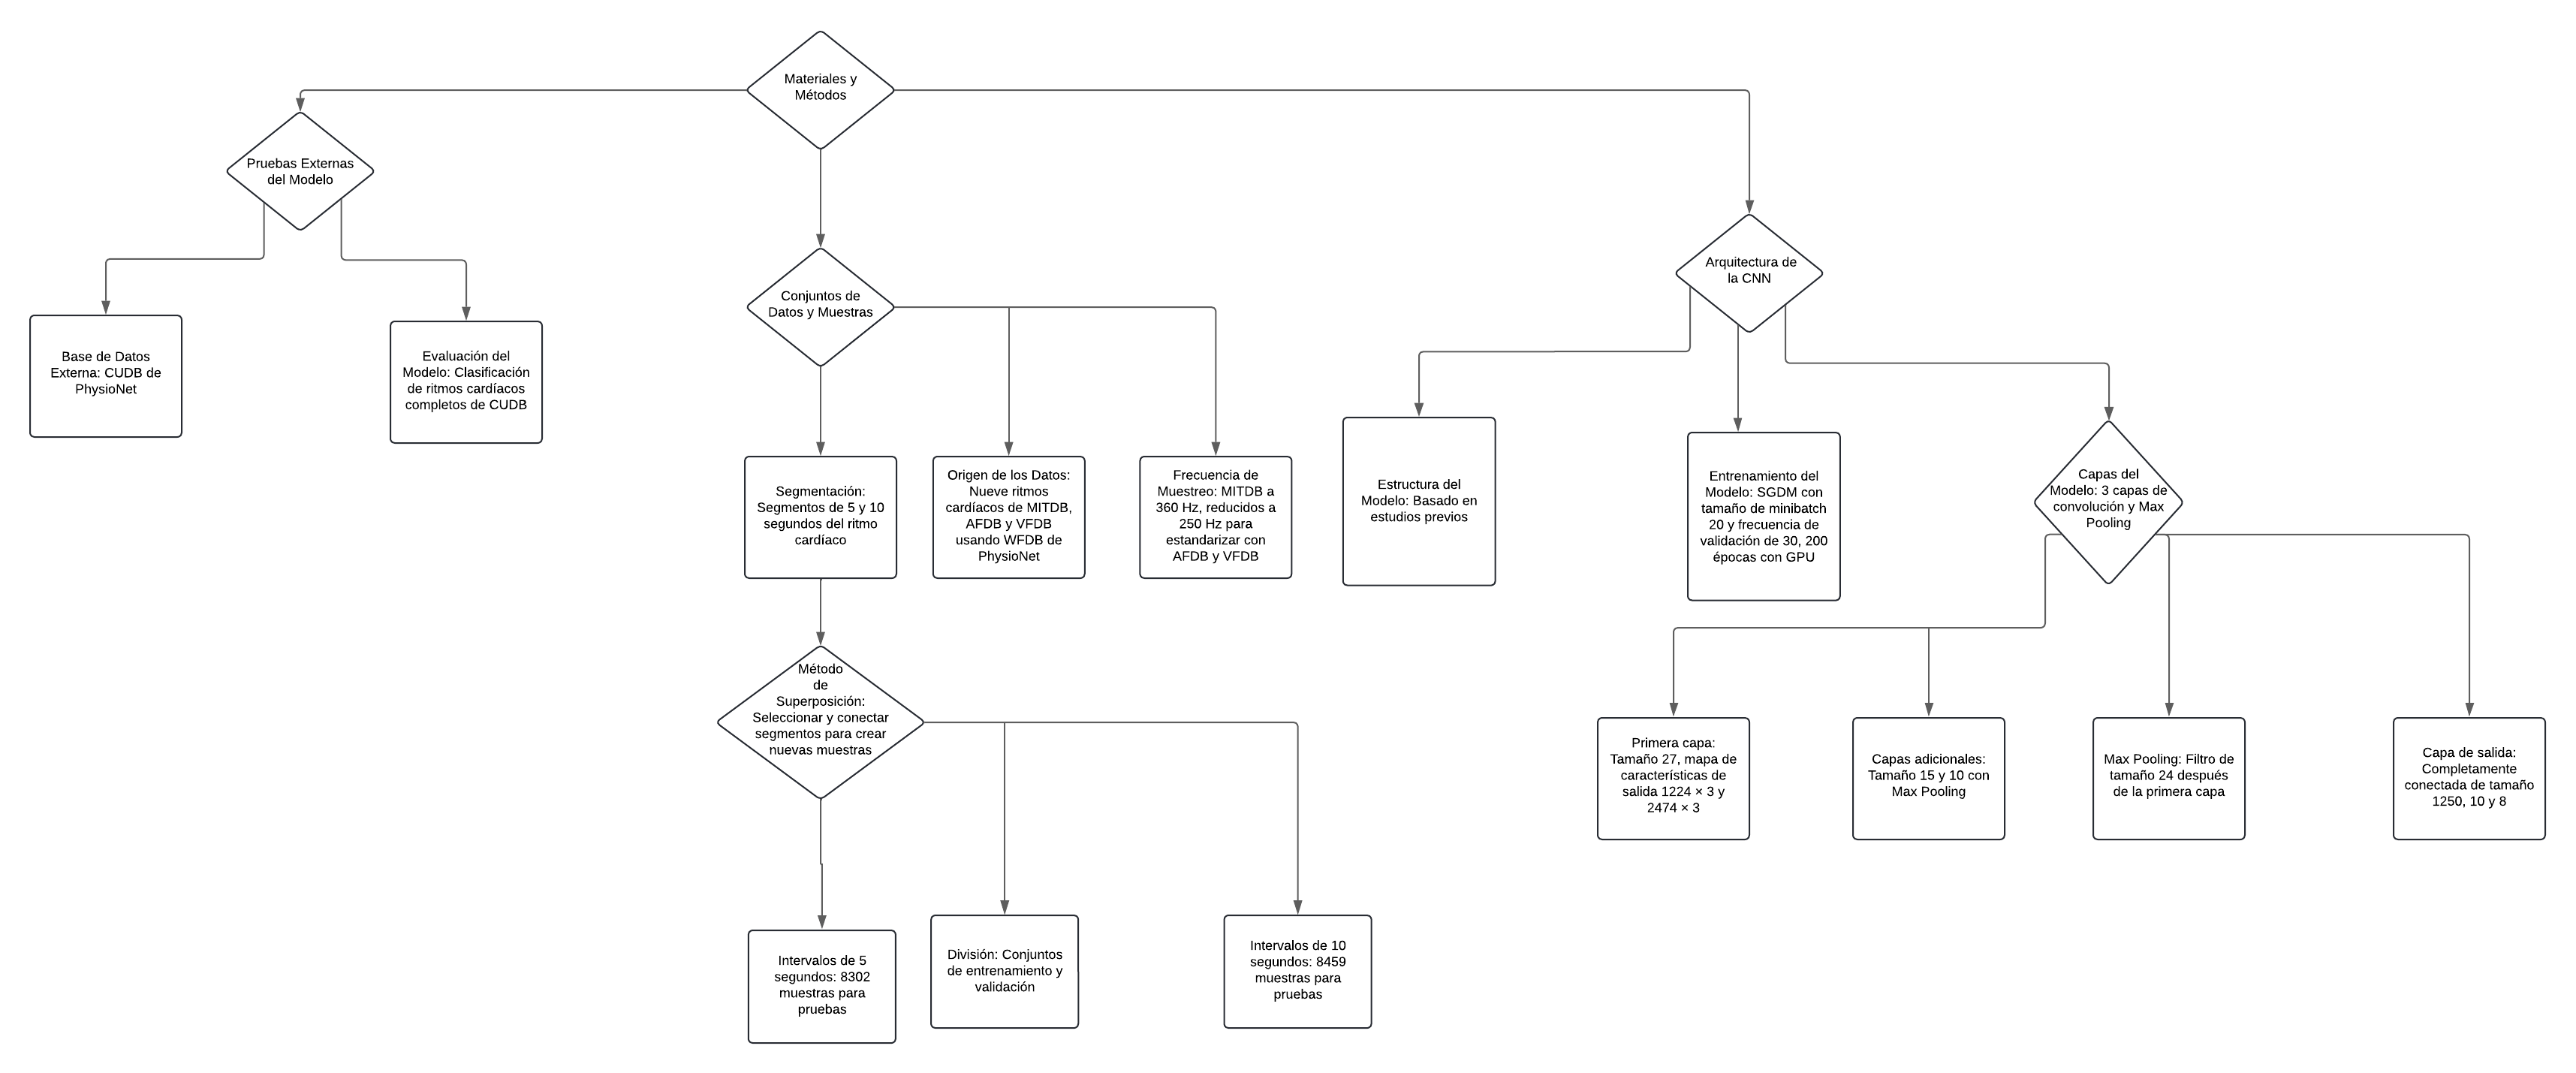

2. Descargar los datos ECGDataDenoised.zip de:
https://figshare.com/collections/ChapmanECG/4560497/1

De la base de datos extraer los registros que correspondan a bradicardia sinusal (SB Sinus Bradycardia) y fibrilación auricular (AFIB Atrial Fibrillation). Esta información está en el archivo Diagnostics.xlsx

In [35]:
import pandas as pd
import scipy.signal as sis
import os
import numpy as np
import matplotlib.pyplot as plt

In [36]:
diagnostics_path = 'Diagnostics.xlsx'
diagnostics_df = pd.read_excel(diagnostics_path)
sbyafib_df=diagnostics_df[diagnostics_df['Rhythm'].isin(['AFIB', 'SB'])]
needed_files = sbyafib_df['FileName'].tolist()

3. De estos registros los análisis para el presente proyecto deben hacerse en la derivación II

Programar las fórmulas 1 al 4 que se encuentran en el artículo (15%). Consultar que significado y utilidad del biespectro (Realice la gráfica) (5%)
https://arxiv.org/pdf/1809.08451


In [37]:
ruta = r'C:\Users\andre\Downloads\ECGDataDenoised\ECGDataDenoised'

###Biespectro
El bispectrum es una herramienta de análisis de señales que forma parte del análisis espectral de orden superior (Higher Order Spectral Analysis, HOSA). A diferencia del espectro de potencia tradicional, que analiza la distribución de la energía de una señal en función de la frecuencia, el bispectrum proporciona información adicional sobre las relaciones de fase entre las componentes frecuenciales de la señal.
El bispectrum es la transformación de Fourier de la función de autocorrelación de tercer orden de una señal. Matemáticamente, para una señal 
𝑥(𝑡), el bispectrum 𝐵 (𝑓1,𝑓2) se define como:

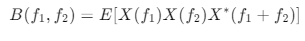 [1]

Se utiliza principalmente para:

* Detección de No Linealidades: El bispectrum es particularmente útil para detectar y caracterizar no linealidades en señales. Esto es posible porque las no linealidades generan acoplamiento de fase entre diferentes componentes frecuenciales, lo cual es capturado por el bispectrum.

* Identificación de Interacciones de Fase: A diferencia del espectro de potencia, que solo proporciona información sobre la magnitud de las componentes frecuenciales, el bispectrum también informa sobre las relaciones de fase entre estas componentes. Esto es crucial para entender las interacciones y acoplamientos en sistemas complejos.

* Reducción de Ruido: El bispectrum puede diferenciar entre señales de origen dinámico y componentes de ruido. Las componentes de ruido no muestran coherencia de fase, mientras que las componentes de señal sí lo hacen. Por lo tanto, el bispectrum puede ser utilizado para filtrar el ruido y extraer la señal de interés.

* Aplicaciones en Biomedicina: En el análisis de señales biomédicas, como ECG y EEG, el bispectrum se utiliza para detectar y caracterizar patrones asociados con diversas condiciones médicas, como arritmias cardíacas y epilepsia.

* 3.1.1 Detrending

Para este caso se utiliza una libreria ya definida (detrend), de la libreria scipy y se importo la función como sis (scipy.signal)

In [38]:
sis.detrend

<function scipy.signal._signaltools.detrend(data, axis=-1, type='linear', bp=0, overwrite_data=False)>

* 3.1.2 Compression

In [39]:
def compress(timeseries: np.ndarray) -> np.ndarray:
  """
    Normaliza la señal recibida, poniendola entre 0 y 1.
  """
  max = timeseries.max()
  min = timeseries.min()
  return (timeseries - min) / (max - min)

* 3.2 Power Spectral analysis


In [40]:
dff = pd.read_csv(f'{ruta}/{os.listdir(ruta)[0]}',delimiter=',',names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])['II']
dff.head()

0   -2.116300
1    0.028884
2    2.204800
3    4.209700
4    5.657600
Name: II, dtype: float64

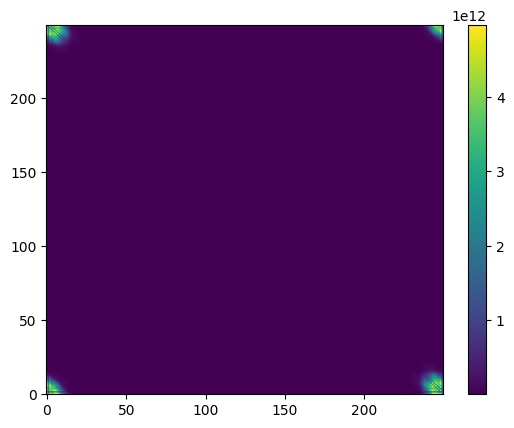

In [41]:
def Bispectrum(timeseries: np.ndarray, largo_segmento: int) -> np.ndarray:
  """
    Genera el bispectrum de la señal.
  """
  nsegmentos = int(np.ceil(len(timeseries) / largo_segmento))
  segmentos = np.array_split(timeseries, nsegmentos)
  bispectro = np.zeros((segmentos[0].size, segmentos[0].size), dtype = complex)
  for segmento in segmentos:
    X = np.fft.fft(segmento, n=len(segmento))
    F = np.fft.fftfreq(len(segmento), 1/500)

    # Crear una malla de índices para f1 y f2
    f1_indices, f2_indices = np.meshgrid(np.arange(segmento.size), np.arange(segmento.size), indexing='ij')
    
    # Calcular los índices f1_f2
    f1_f2_indices = (f1_indices + f2_indices) % segmento.size

    # Asegurarse de que todas las operaciones tienen las mismas dimensiones
    bispectro[f1_indices, f2_indices] += X[f1_indices] * X[f2_indices] * np.conj(X[f1_f2_indices])

  return bispectro, nsegmentos

sol, nsegmentos = Bispectrum(dff.to_numpy(), 250)
plt.imshow(np.abs(sol), aspect = 'auto', origin = 'lower')
plt.colorbar()
plt.show()

* 3.3 Higher Order Spectral Analysis


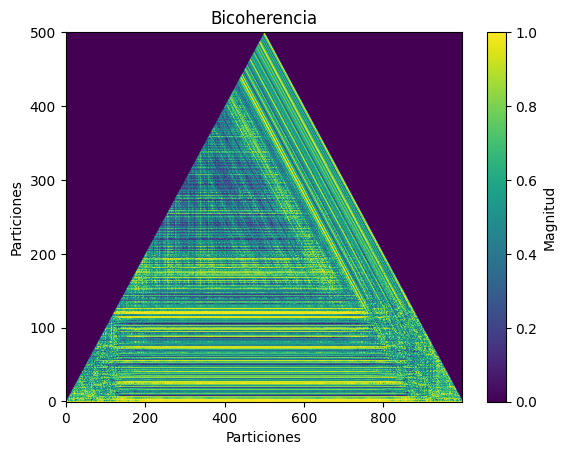

In [42]:
def Bicoherence(timeseries: np.ndarray, largo_segmento: int) -> np.ndarray:
  """
    Genera la bicoherencia de la señal.
  """
  bispectro, nsegmentos = Bispectrum(timeseries, largo_segmento)
  bicoherence = np.zeros((bispectro.shape[0], bispectro.shape[1]), dtype = complex)
  bicoherence[:, :] = bispectro / (np.abs(bispectro))

  
  bicoherence_simetric = np.zeros((bicoherence.shape[0], bicoherence.shape[1]), dtype = float)
  # Se aplica simetria
  for f1 in range(bicoherence.shape[0]):
    bicoherence_simetric[f1, f1:bicoherence.shape[1]-f1] = bicoherence[f1, f1:bicoherence.shape[1]-f1]


  return np.abs(bicoherence_simetric), nsegmentos

sol, nsegmentos = Bicoherence(dff, 1000)
plt.imshow(np.abs(sol), aspect = 'auto', origin = 'lower')
plt.colorbar(label = 'Magnitud')
plt.ylim([-0.5, sol.shape[1]/2+0.5])
plt.xlabel('Particiones')
plt.ylabel('Particiones')
plt.title('Bicoherencia')
plt.show()

4. Para cada señal extraer la frecuencia que contiene la máxima potencia y Gráfiquela (15%)

{'MFrecuencia': 1.9}

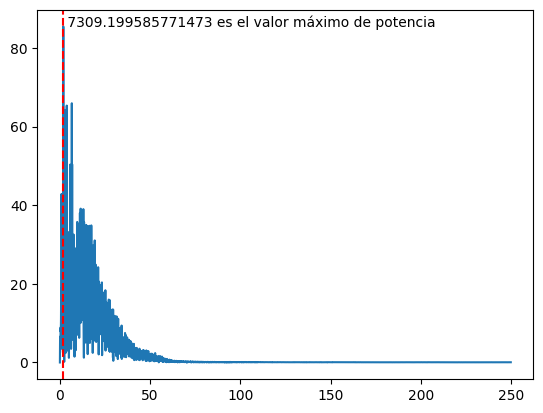

In [43]:
def extractNGraph(signal: np.ndarray, graph: bool = True) -> dict:
    FT = np.fft.fft(signal)
    FT = np.abs(FT[:len(FT)//2])
    freqs = np.fft.fftfreq(len(signal), 1/500)
    freqs = freqs[:len(freqs)//2]
    power = np.abs(FT)**2
    maxV = np.argmax(power)
    maxFf = round(freqs[maxV], 5)
    max = power[maxV]  
    maxF = FT[maxV]  
    if graph:   
        plt.figure()
        plt.plot(freqs, FT)
        plt.axvline(maxFf, color = 'r', linestyle = '--', label = 'Maxima Freq')
        plt.text(maxFf, maxF, f' {power[maxV]} es el valor máximo de potencia')
    return {'MFrecuencia' : maxFf}

s = sis.detrend(compress(sis.detrend(pd.read_csv(os.path.join(ruta, os.listdir(ruta)[95]), names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])['II'])))
extractNGraph(s)

5. Para cada señal sumar el número de frecuencias que son significativas para bicoherencia (cuales tienen un valor superior a ![image.png](attachment:image.png) (20%)

In [44]:
def sumaFreqs(timeseries: np.ndarray, lengthSegmentos: int) -> int:
    '''
        Recibe un numpy array y longitud de los segmentos para posteriormente retornar
        un valor entero que da el numero de valores de frecuencia que son importantes
        para la bicoherencia.
    '''
    B, N = Bicoherence(timeseries, lengthSegmentos)
    return {'NFrecuencias' : np.sum(B > np.sqrt(9.2/(2*N)))}

sumaFreqs(dff, 1000)

{'NFrecuencias': 38003}

6. Crear una rutina que aplique sobre todos los archivos de la base de datos las rutina 3 al 5 y almacene los resultados en un dataframe donde se pueda registro, tipo de patología y el frecuencia de máxima potencia (fMP) y suma de frecuencias significativas en bicoherencia (sFSB):

![image-2.png](attachment:image-2.png)

In [45]:
dataframe = pd.DataFrame(columns=['patologia', 'MFrecuencia', 'NFrecuencias'])
def FullDF(lista: list[str], n: int = 5):
    a = 0
    for i in lista:
        csv = sis.detrend(compress(sis.detrend(pd.read_csv(os.path.join(ruta, i), names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])['II'])))
        row = diagnostics_df[diagnostics_df.FileName == i.split('.')[0]]
        name = row.FileName.to_numpy()[0]
        patologia = row.Rhythm.to_numpy()[0]
        maximos = extractNGraph(csv, graph = False)
        sumas = sumaFreqs(csv, 500)
        total = {
            'patologia': patologia
        }
        total.update(maximos)
        total.update(sumas)
        dataframe.loc[name] = total
        a+=1
        print(f'{a}/{n}')
        if a == n:
            return dataframe
listaa = os.listdir(ruta)
FullDF(listaa)

1/5
2/5
3/5
4/5
5/5


,patologia,MFrecuencia,NFrecuencias
MUSE_20180111_155154_74000,AFIB,9.7,31044
MUSE_20180111_155203_15000,AFIB,2.7,34160
MUSE_20180111_155758_17000,SB,3.7,8482
MUSE_20180111_155839_67000,SB,2.9,19772
MUSE_20180111_155859_36000,SB,2.8,21063


7. Para las señales de análisis del punto 2 aplicar las rutinas del punto 3 al 5 y hacer un informe que permita evidenciar las diferencias entre las señales SB y AFIB utilizando las herramientas de estadística descriptiva (5%)

In [46]:
listaF = [i for i in os.listdir(ruta) if i.split('.')[0] in needed_files]
senal = FullDF(listaF, len(listaF))

1/5669
2/5669
3/5669
4/5669
5/5669
6/5669
7/5669
8/5669
9/5669
10/5669
11/5669
12/5669
13/5669
14/5669
15/5669
16/5669
17/5669
18/5669
19/5669
20/5669
21/5669
22/5669
23/5669
24/5669
25/5669
26/5669
27/5669
28/5669
29/5669
30/5669
31/5669
32/5669
33/5669
34/5669
35/5669
36/5669
37/5669
38/5669
39/5669
40/5669
41/5669
42/5669
43/5669
44/5669
45/5669
46/5669
47/5669
48/5669
49/5669
50/5669
51/5669
52/5669
53/5669
54/5669
55/5669
56/5669
57/5669
58/5669
59/5669
60/5669
61/5669
62/5669
63/5669
64/5669
65/5669
66/5669
67/5669
68/5669
69/5669
70/5669
71/5669
72/5669
73/5669
74/5669
75/5669
76/5669
77/5669
78/5669
79/5669
80/5669
81/5669
82/5669
83/5669
84/5669
85/5669
86/5669
87/5669
88/5669
89/5669
90/5669
91/5669
92/5669
93/5669
94/5669
95/5669
96/5669
97/5669
98/5669
99/5669
100/5669
101/5669
102/5669
103/5669
104/5669
105/5669
106/5669
107/5669
108/5669
109/5669
110/5669
111/5669
112/5669
113/5669
114/5669
115/5669
116/5669
117/5669
118/5669
119/5669
120/5669
121/5669
122/5669
123/5669
1

In [52]:
senal.to_csv(os.path.join(os.getcwd(), 'datos.csv'), index = False)

In [54]:
senal = pd.read_csv(os.path.join(os.getcwd(), 'datos.csv'))
senal

,patologia,MFrecuencia,NFrecuencias
0,AFIB,9.7,31044
1,AFIB,2.7,34160
2,SB,3.7,8482
3,SB,2.9,19772
4,SB,2.8,21063
...,...,...,...
5664,AFIB,12.4,31304
5665,AFIB,3.9,27056
5666,AFIB,3.2,22794
5667,AFIB,4.1,20021


In [55]:
a, b = senal.groupby('patologia')

In [56]:
a[1]

,patologia,MFrecuencia,NFrecuencias
0,AFIB,9.7,31044
1,AFIB,2.7,34160
5,AFIB,2.2,20524
7,AFIB,4.2,21849
9,AFIB,2.9,23362
...,...,...,...
5664,AFIB,12.4,31304
5665,AFIB,3.9,27056
5666,AFIB,3.2,22794
5667,AFIB,4.1,20021


In [57]:
b[1]

,patologia,MFrecuencia,NFrecuencias
2,SB,3.7,8482
3,SB,2.9,19772
4,SB,2.8,21063
6,SB,2.8,30629
8,SB,0.8,26386
...,...,...,...
5526,SB,5.7,24499
5528,SB,2.5,26190
5533,SB,6.9,33542
5534,SB,1.9,24353


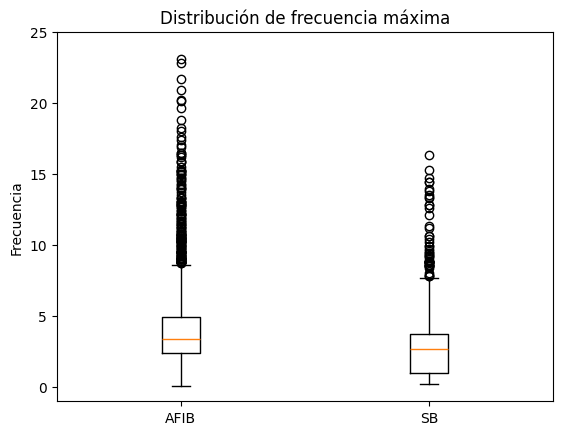

In [68]:
plt.figure()
plt.boxplot([a[1].MFrecuencia, b[1].MFrecuencia], labels = [a[0], b[0]])
plt.ylabel('Frecuencia')
plt.title('Distribución de frecuencia máxima')
plt.ylim([-1, 25])
plt.show()

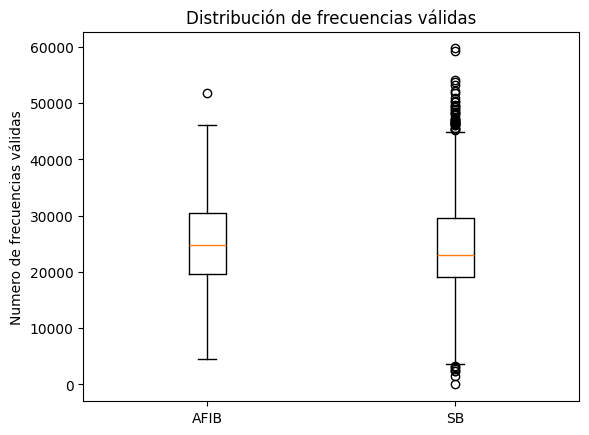

In [69]:
plt.figure()
plt.boxplot([a[1].NFrecuencias, b[1].NFrecuencias], labels = [a[0], b[0]])
plt.title('Distribución de frecuencias válidas')
plt.ylabel('Numero de frecuencias válidas')
plt.show()

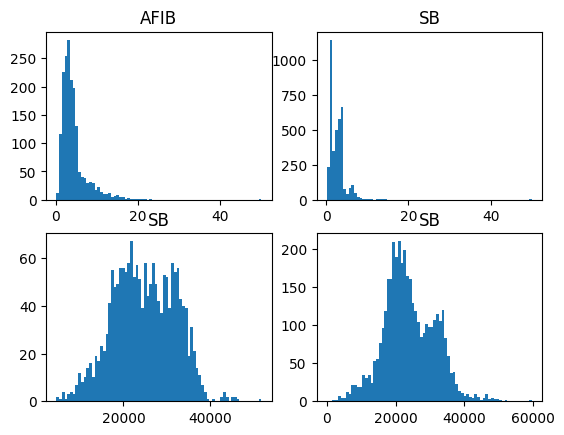

In [67]:
plt.subplot(2,2,1)
plt.hist(a[1].MFrecuencia, bins = 75)
plt.title(a[0])
plt.subplot(2,2,2)
plt.hist(b[1].MFrecuencia, bins = 75)
plt.title(b[0])
plt.subplot(2,2,3)
plt.hist(a[1].NFrecuencias, bins = 75)
plt.title(b[0])
plt.subplot(2,2,4)
plt.hist(b[1].NFrecuencias, bins = 75)
plt.title(b[0])
plt.show()

8. Indicar si hay o no diferencias estadísticas entre las características espectrales del punto 4 y 5 para las dos poblaciones de estudio (5%)












9.Hacer un informe con todos los puntos anteriores (15%)

Trabajo sin sustentar no se califica

# **Bibliografía**

[1] Mariño, W. A. (2016). BIESPECTRO. www.academia.edu. https://www.academia.edu/28141592/BIESPECTRO 